# INTENT CLASSIFICATION

Intent classification is the automated categorization of text data based on customer goals. In essence, an intent classifier automatically analyzes texts and categorizes them into intents such as Purchase, Downgrade, Unsubscribe, and Demo Request.

For Example: if i enquiry about ticket availabilty from Airport Counter, it will be enquiry category.

# Import libraries

In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import matplotlib.pyplot as plt

# Load data

In [40]:
df = pd.read_csv("atis_intents_train.csv")
df.columns = ["intent","text"]
df.head()

,intent,text
0,atis_flight,what flights are available from pittsburgh to...
1,atis_flight_time,what is the arrival time in san francisco for...
2,atis_airfare,cheapest airfare from tacoma to orlando
3,atis_airfare,round trip fares from pittsburgh to philadelp...
4,atis_flight,i need a flight tomorrow from columbus to min...


In [41]:
df['intent'].value_counts()

atis_flight            3665
atis_airfare            423
atis_ground_service     255
atis_airline            157
atis_abbreviation       147
atis_aircraft            81
atis_flight_time         54
atis_quantity            51
Name: intent, dtype: int64

In [42]:
df.head(5)

,intent,text
0,atis_flight,what flights are available from pittsburgh to...
1,atis_flight_time,what is the arrival time in san francisco for...
2,atis_airfare,cheapest airfare from tacoma to orlando
3,atis_airfare,round trip fares from pittsburgh to philadelp...
4,atis_flight,i need a flight tomorrow from columbus to min...


In [43]:
df.describe()

,intent,text
count,4833,4833
unique,8,4498
top,atis_flight,what is fare code h
freq,3665,8


<Figure size 3600x3600 with 0 Axes>

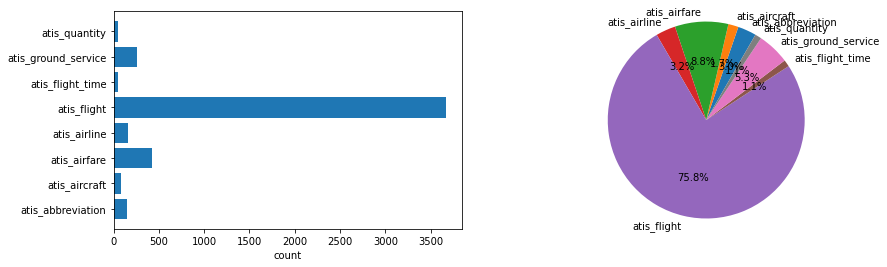

In [50]:
#distribution

plt.figure(figsize=(50,50))
fig, axs = plt.subplots(1,2)
plt.subplots_adjust(right = 1.9)
grouped = snips_df.groupby("intent").count().reset_index()
axs[0].barh(grouped["intent"], grouped["text"])
axs[0].set_xlabel("count")
axs[1].pie(grouped["text"], labels=grouped["intent"], startangle=60, autopct='%1.1f%%')
axs[1].axis('equal')
plt.savefig("class_dist.jpg", bbox_inches='tight', dpi = 800)
plt.show()

# Prepare data for training (spit test and train)

In [52]:


ratio = 0.2
Rand_stat = 10
np.random.seed(Rand_stat)
tf.random.set_seed(Rand_stat)

X_train, X_test, y_train, y_test = train_test_split(df["text"], df["intent"], 
                                                    test_size = ratio, random_state = Rand_stat)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3866,) (967,) (3866,) (967,)


## Feature Extraction

In [53]:
#Initialize a Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(X_train))

#Convert text to sequences
X_seq = tokenizer.texts_to_sequences(list(X_train))
X_test_seq = tokenizer.texts_to_sequences(list(X_test))

In [55]:
X_seq_len = [len(x) for x in X_seq]
X_max_seq_len = max(X_seq_len)
print(X_max_seq_len)

X_test_seq_len = [len(x) for x in X_test_seq]
X_max_test_seq_len = max(X_test_seq_len)
print(X_max_test_seq_len)

Max_seq_len = max(X_max_seq_len, X_max_test_seq_len)
print(Max_seq_len)

42
45
45


In [56]:


#pad the sequences
X = pad_sequences(X_seq, maxlen = Max_seq_len, padding = 'post')
X_test = pad_sequences(X_test_seq, maxlen = Max_seq_len, padding = 'post')

print(X.shape, X_test.shape)

(3866, 45) (967, 45)


In [57]:
#Convert labels to one-hot vectors

y = y_train.to_numpy()
encoder = LabelEncoder()
encoder.fit(y)

encoded_y = encoder.transform(y)
y_train_encoded = utils.to_categorical(encoded_y)

y_test = y_test.to_numpy()
encoded_y_test = encoder.transform(y_test)
y_test_encoded = utils.to_categorical(encoded_y_test)

print(y_train_encoded.shape, y_test_encoded.shape)

(3866, 8) (967, 8)


# Model Training (LSTM)

In [60]:
VAL_SPLIT = 0.1
BATCH_SIZE = 32
EPOCHS = 10
EMBEDDING_DIM = 16
NUM_UNITS = 16
NUM_CLASSES = len(df['intent'].unique())
VOCAB_SIZE = len(tokenizer.word_index) + 1
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_DIM, input_length = MAX_SEQ_LEN, mask_zero = True))
lstm_model.add(LSTM(NUM_UNITS, activation='relu'))
lstm_model.add(Dense(NUM_CLASSES, activation='softmax'))

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[Precision(), Recall(), 'accuracy'])

lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 45, 16)            13184     
                                                                 
 lstm_3 (LSTM)               (None, 16)                2112      
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
Total params: 15,432
Trainable params: 15,432
Non-trainable params: 0
_________________________________________________________________


In [62]:
lstm_history = lstm_model.fit(X, y_train_encoded, batch_size = BATCH_SIZE, epochs = EPOCHS, verbose = 1, validation_split = VAL_SPLIT)


Epoch 1/10
109/109 [==============================] - 4s 40ms/step - loss: 0.3065 - precision_3: 0.9674 - recall_3: 0.8370 - accuracy: 0.8962 - val_loss: 0.3278 - val_precision_3: 0.9566 - val_recall_3: 0.8553 - val_accuracy: 0.8889
Epoch 2/10
109/109 [==============================] - 4s 39ms/step - loss: 0.2881 - precision_3: 0.9699 - recall_3: 0.8511 - accuracy: 0.9037 - val_loss: 0.3218 - val_precision_3: 0.9540 - val_recall_3: 0.8579 - val_accuracy: 0.8941
Epoch 3/10
109/109 [==============================] - 4s 40ms/step - loss: 0.2714 - precision_3: 0.9706 - recall_3: 0.8620 - accuracy: 0.9126 - val_loss: 0.3131 - val_precision_3: 0.9542 - val_recall_3: 0.8605 - val_accuracy: 0.8966
Epoch 4/10
109/109 [==============================] - 4s 40ms/step - loss: 0.2564 - precision_3: 0.9727 - recall_3: 0.8704 - accuracy: 0.9201 - val_loss: 0.3054 - val_precision_3: 0.9574 - val_recall_3: 0.8708 - val_accuracy: 0.9018
Epoch 5/10
109/109 [==============================] - 4s 39ms/step -


# Plot learning curves

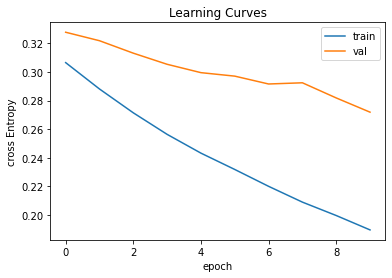

In [67]:
plt.title('Learning Curves')
plt.xlabel('epoch')
plt.ylabel('cross Entropy')
plt.plot(lstm_history.history['loss'], label='train')
plt.plot(lstm_history.history['val_loss'], label='val')
plt.legend()
plt.savefig("learning_curve.jpg", bbox_inches='tight', dpi = 300)
plt.show()

### Predict on test

In [64]:
#Evaluate the model performance on test data
lstm_score = lstm_model.evaluate(X_test, y_test_encoded, batch_size = BATCH_SIZE, verbose = 1)


31/31 [==============================] - 0s 11ms/step - loss: 1.3309 - precision_3: 0.9446 - recall_3: 0.8821 - accuracy: 0.9100


### Classification metrics

In [65]:
y_pred_labels_lstm = [encoder.classes_[x] for x in np.argmax(lstm_model.predict(X_test), axis=-1)]
print(metrics.classification_report(y_test, y_pred_labels_lstm))

                     precision    recall  f1-score   support

  atis_abbreviation       0.87      0.96      0.91        27
      atis_aircraft       0.54      0.58      0.56        12
       atis_airfare       0.64      0.88      0.74        74
       atis_airline       0.00      0.00      0.00        41
        atis_flight       0.95      0.99      0.97       743
   atis_flight_time       0.00      0.00      0.00        15
atis_ground_service       0.96      0.96      0.96        48
      atis_quantity       1.00      0.14      0.25         7

           accuracy                           0.91       967
          macro avg       0.62      0.56      0.55       967
       weighted avg       0.86      0.91      0.88       967



C:\Users\Shristi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shristi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Shristi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

# Prediction

In [66]:
sentence = "flights from burbank to st. louis on monday"
input_seq = tokenizer.texts_to_sequences([sentence])
input_features = pad_sequences(input_seq, maxlen = MAX_SEQ_LEN, padding = 'post')
probs = lstm_model.predict(input_features)
predicted_y = probs.argmax(axis=-1)
print(encoder.classes_[predicted_y][0])

atis_flight
